In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from src.models.siamese_triplet.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet, ClassificationNet
from src.models.siamese_triplet.metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/home/jiajunb/miniconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/60000 (0%)]	Loss: 2.355050	Accuracy: 9.765625
Train: [12800/60000 (21%)]	Loss: 3.438436	Accuracy: 10.263480392156863
Train: [25600/60000 (43%)]	Loss: 2.323336	Accuracy: 9.881652227722773
Train: [38400/60000 (64%)]	Loss: 2.305358	Accuracy: 10.288182947019868
Train: [51200/60000 (85%)]	Loss: 2.301236	Accuracy: 10.645988805970148
Epoch: 1/20. Train set: Average loss: 2.5492	Accuracy: 10.661666666666667
Epoch: 1/20. Validation set: Average loss: 2.3022	Accuracy: 11.35
Train: [0/60000 (0%)]	Loss: 2.296960	Accuracy: 9.375
Train: [12800/60000 (21%)]	Loss: 2.301719	Accuracy: 11.044730392156863
Train: [25600/60000 (43%)]	Loss: 2.300036	Accuracy: 11.347462871287128
Train: [38400/60000 (64%)]	Loss: 2.179168	Accuracy: 13.873654801324504
Train: [51200/60000 (85%)]	Loss: 1.557702	Accuracy: 20.38829291044776
Epoch: 2/20. Train set: Average loss: 1.9389	Accuracy: 26.355
Epoch: 2/20. Validation set: Average loss: 0.8525	Accuracy: 72.9
Train: [0/60000 (0%)]	Loss: 0.796986	Accuracy: 75.78125
Tr

Train: [38400/60000 (64%)]	Loss: 0.012773	Accuracy: 99.64300496688742
Train: [51200/60000 (85%)]	Loss: 0.016761	Accuracy: 99.59771455223881
Epoch: 18/20. Train set: Average loss: 0.0143	Accuracy: 99.60333333333334
Epoch: 18/20. Validation set: Average loss: 0.0722	Accuracy: 98.81
Train: [0/60000 (0%)]	Loss: 0.014437	Accuracy: 99.21875
Train: [12800/60000 (21%)]	Loss: 0.015079	Accuracy: 99.55575980392157
Train: [25600/60000 (43%)]	Loss: 0.012847	Accuracy: 99.60550742574257
Train: [38400/60000 (64%)]	Loss: 0.013968	Accuracy: 99.6042011589404
Train: [51200/60000 (85%)]	Loss: 0.014661	Accuracy: 99.609375
Epoch: 19/20. Train set: Average loss: 0.0139	Accuracy: 99.6
Epoch: 19/20. Validation set: Average loss: 0.0716	Accuracy: 98.85
Train: [0/60000 (0%)]	Loss: 0.012608	Accuracy: 100.0
Train: [12800/60000 (21%)]	Loss: 0.012314	Accuracy: 99.65533088235294
Train: [25600/60000 (43%)]	Loss: 0.016296	Accuracy: 99.60550742574257
Train: [38400/60000 (64%)]	Loss: 0.010996	Accuracy: 99.6248965231788
Tr

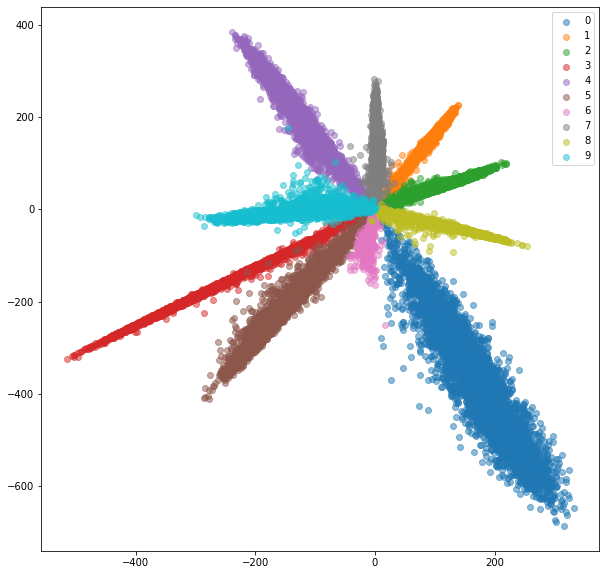

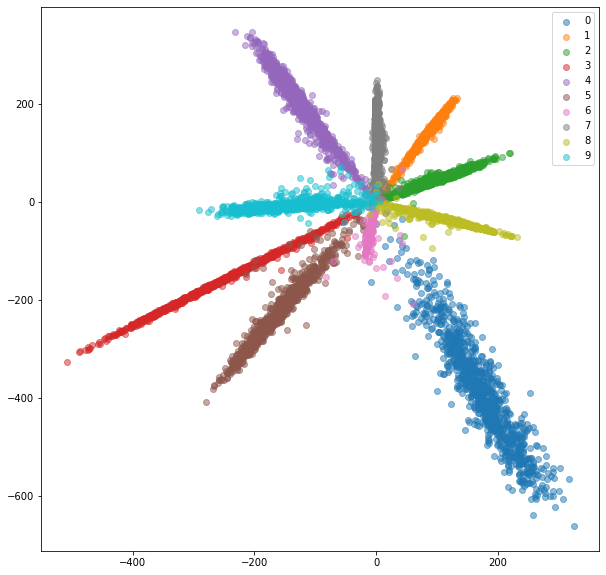

In [6]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [7]:
# Set up data loaders
from src.models.siamese_triplet.datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet, SiameseNet
from src.models.siamese_triplet.losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

/home/jiajunb/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/jiajunb/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/jiajunb/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/jiajunb/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [8]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.232899
Train: [12800/60000 (21%)]	Loss: 0.065140
Train: [25600/60000 (43%)]	Loss: 0.038218
Train: [38400/60000 (64%)]	Loss: 0.028878
Train: [51200/60000 (85%)]	Loss: 0.024072
Epoch: 1/20. Train set: Average loss: 0.0367
Epoch: 1/20. Validation set: Average loss: 0.0181
Train: [0/60000 (0%)]	Loss: 0.023612
Train: [12800/60000 (21%)]	Loss: 0.018630
Train: [25600/60000 (43%)]	Loss: 0.015366
Train: [38400/60000 (64%)]	Loss: 0.013150
Train: [51200/60000 (85%)]	Loss: 0.011009
Epoch: 2/20. Train set: Average loss: 0.0140
Epoch: 2/20. Validation set: Average loss: 0.0107
Train: [0/60000 (0%)]	Loss: 0.013227
Train: [12800/60000 (21%)]	Loss: 0.009703
Train: [25600/60000 (43%)]	Loss: 0.007422
Train: [38400/60000 (64%)]	Loss: 0.008244
Train: [51200/60000 (85%)]	Loss: 0.008676
Epoch: 3/20. Train set: Average loss: 0.0085
Epoch: 3/20. Validation set: Average loss: 0.0081
Train: [0/60000 (0%)]	Loss: 0.005618
Train: [12800/60000 (21%)]	Loss: 0.006335
Train: [25600/60000 (

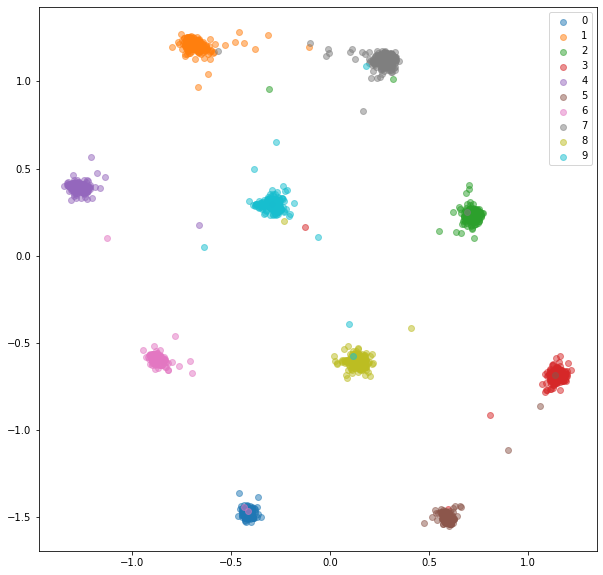

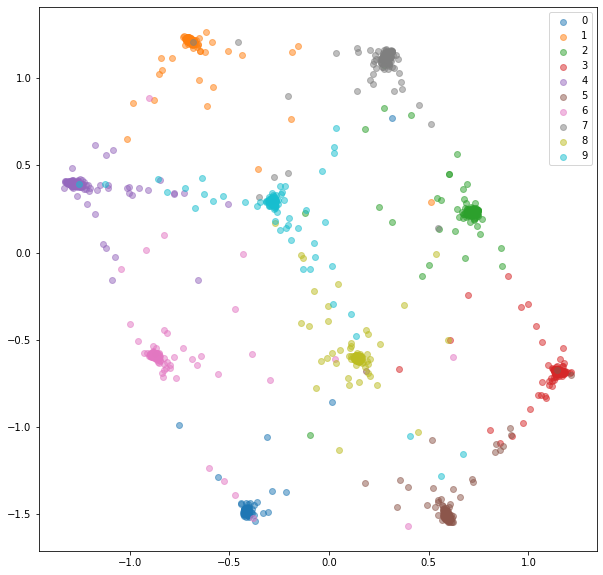

In [9]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [11]:
# Set up data loaders
from src.models.siamese_triplet.datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet, TripletNet
from src.models.siamese_triplet.losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [12]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999545
Train: [12800/60000 (21%)]	Loss: 0.299360
Train: [25600/60000 (43%)]	Loss: 0.141801
Train: [38400/60000 (64%)]	Loss: 0.105237
Train: [51200/60000 (85%)]	Loss: 0.079075
Epoch: 1/20. Train set: Average loss: 0.1451
Epoch: 1/20. Validation set: Average loss: 0.0576
Train: [0/60000 (0%)]	Loss: 0.041418
Train: [12800/60000 (21%)]	Loss: 0.059584
Train: [25600/60000 (43%)]	Loss: 0.050128
Train: [38400/60000 (64%)]	Loss: 0.046666
Train: [51200/60000 (85%)]	Loss: 0.045284
Epoch: 2/20. Train set: Average loss: 0.0497
Epoch: 2/20. Validation set: Average loss: 0.0423
Train: [0/60000 (0%)]	Loss: 0.028793
Train: [12800/60000 (21%)]	Loss: 0.035694
Train: [25600/60000 (43%)]	Loss: 0.031929
Train: [38400/60000 (64%)]	Loss: 0.031663
Train: [51200/60000 (85%)]	Loss: 0.036010
Epoch: 3/20. Train set: Average loss: 0.0337
Epoch: 3/20. Validation set: Average loss: 0.0294
Train: [0/60000 (0%)]	Loss: 0.008181
Train: [12800/60000 (21%)]	Loss: 0.025779
Train: [25600/60000 (

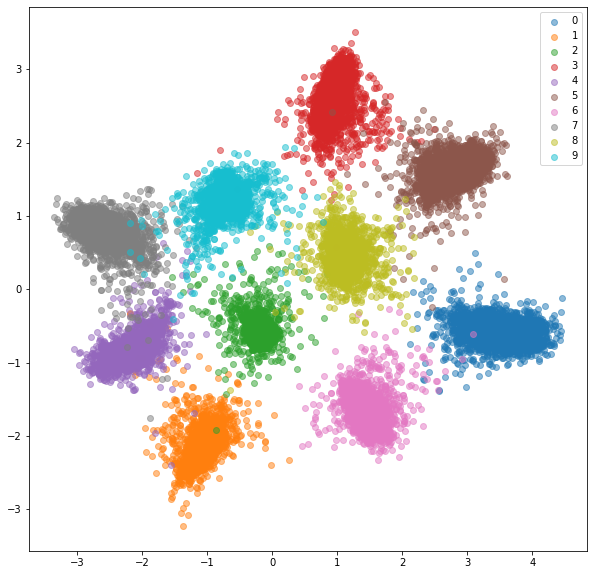

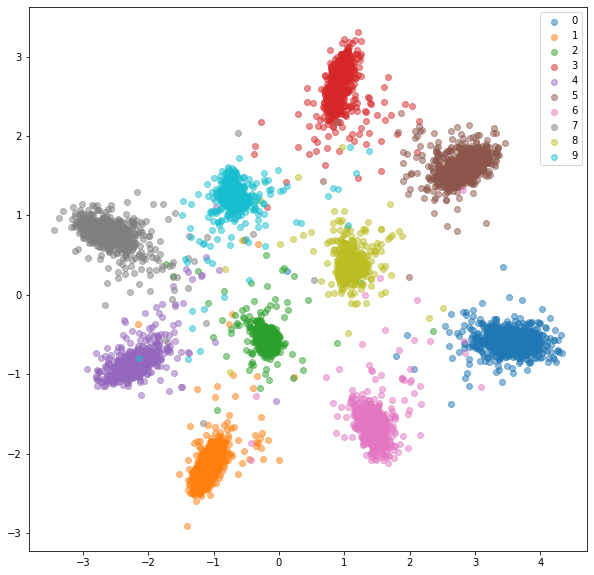

In [13]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [14]:
from src.models.siamese_triplet.datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet
from src.models.siamese_triplet.losses import OnlineContrastiveLoss
from src.models.siamese_triplet.utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [15]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.490958
Train: [12500/60000 (21%)]	Loss: 0.290285
Train: [25000/60000 (42%)]	Loss: 0.148312
Train: [37500/60000 (62%)]	Loss: 0.100431
Train: [50000/60000 (83%)]	Loss: 0.080151
Epoch: 1/20. Train set: Average loss: 0.1423
Epoch: 1/20. Validation set: Average loss: 0.0610
Train: [0/60000 (0%)]	Loss: 0.067956
Train: [12500/60000 (21%)]	Loss: 0.052152
Train: [25000/60000 (42%)]	Loss: 0.045070
Train: [37500/60000 (62%)]	Loss: 0.044374
Train: [50000/60000 (83%)]	Loss: 0.037316
Epoch: 2/20. Train set: Average loss: 0.0438
Epoch: 2/20. Validation set: Average loss: 0.0402
Train: [0/60000 (0%)]	Loss: 0.047877
Train: [12500/60000 (21%)]	Loss: 0.026776
Train: [25000/60000 (42%)]	Loss: 0.029002
Train: [37500/60000 (62%)]	Loss: 0.028058
Train: [50000/60000 (83%)]	Loss: 0.027538
Epoch: 3/20. Train set: Average loss: 0.0271
Epoch: 3/20. Validation set: Average loss: 0.0290
Train: [0/60000 (0%)]	Loss: 0.014539
Train: [12500/60000 (21%)]	Loss: 0.017626
Train: [25000/60000 (

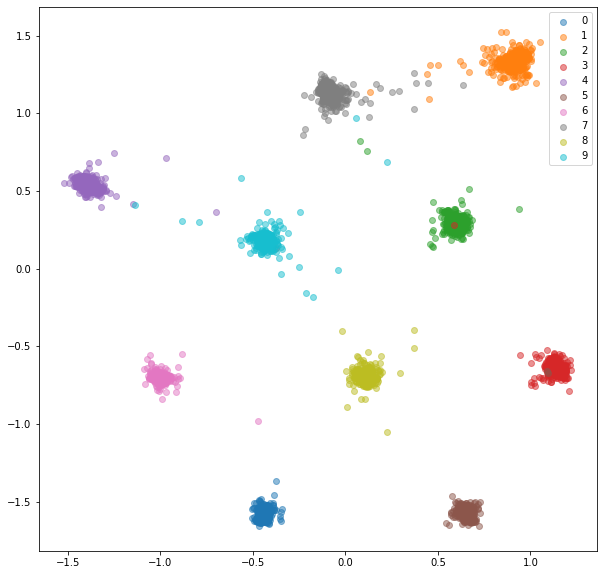

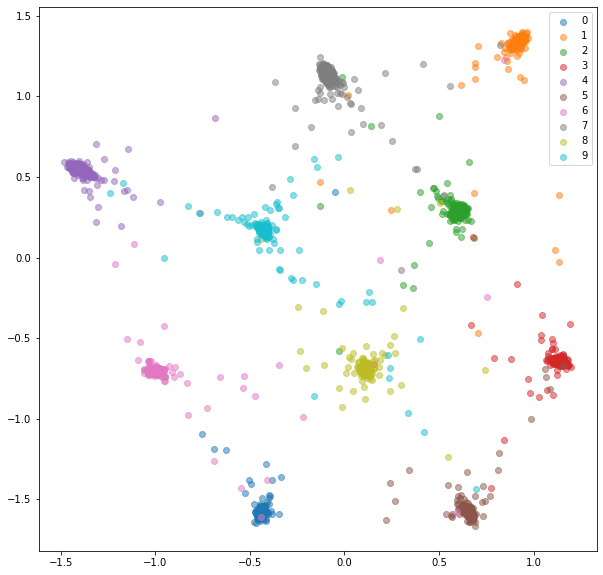

In [16]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [17]:
from src.models.siamese_triplet.datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from src.models.siamese_triplet.networks import EmbeddingNet
from src.models.siamese_triplet.losses import OnlineTripletLoss
from src.models.siamese_triplet.utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from src.models.siamese_triplet.metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [18]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999547	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.981482	Average nonzero triplets: 2588.8823529411766
Train: [25000/60000 (42%)]	Loss: 0.951774	Average nonzero triplets: 2268.079207920792
Train: [37500/60000 (62%)]	Loss: 1.012544	Average nonzero triplets: 2038.271523178808
Train: [50000/60000 (83%)]	Loss: 0.970191	Average nonzero triplets: 1872.4676616915424
Epoch: 1/20. Train set: Average loss: 0.9763	Average nonzero triplets: 1760.55230125523
Epoch: 1/20. Validation set: Average loss: 0.8723	Average nonzero triplets: 1261.820512820513
Train: [0/60000 (0%)]	Loss: 0.734446	Average nonzero triplets: 1276.0
Train: [12500/60000 (21%)]	Loss: 1.043374	Average nonzero triplets: 1070.1764705882354
Train: [25000/60000 (42%)]	Loss: 1.000205	Average nonzero triplets: 1016.2871287128713
Train: [37500/60000 (62%)]	Loss: 1.003927	Average nonzero triplets: 976.1456953642385
Train: [50000/60000 (83%)]	Loss: 1.046353	Average nonzero triplets: 952.

Train: [0/60000 (0%)]	Loss: 0.340850	Average nonzero triplets: 260.0
Train: [12500/60000 (21%)]	Loss: 0.280035	Average nonzero triplets: 38.666666666666664
Train: [25000/60000 (42%)]	Loss: 0.340134	Average nonzero triplets: 45.43564356435643
Train: [37500/60000 (62%)]	Loss: 0.238473	Average nonzero triplets: 43.05298013245033
Train: [50000/60000 (83%)]	Loss: 0.410284	Average nonzero triplets: 46.91044776119403
Epoch: 15/20. Train set: Average loss: 0.2973	Average nonzero triplets: 42.99163179916318
Epoch: 15/20. Validation set: Average loss: 0.9568	Average nonzero triplets: 371.6923076923077
Train: [0/60000 (0%)]	Loss: 0.221102	Average nonzero triplets: 26.0
Train: [12500/60000 (21%)]	Loss: 0.242646	Average nonzero triplets: 32.64705882352941
Train: [25000/60000 (42%)]	Loss: 0.242156	Average nonzero triplets: 32.82178217821782
Train: [37500/60000 (62%)]	Loss: 0.243779	Average nonzero triplets: 33.40397350993378
Train: [50000/60000 (83%)]	Loss: 0.350411	Average nonzero triplets: 37.1641

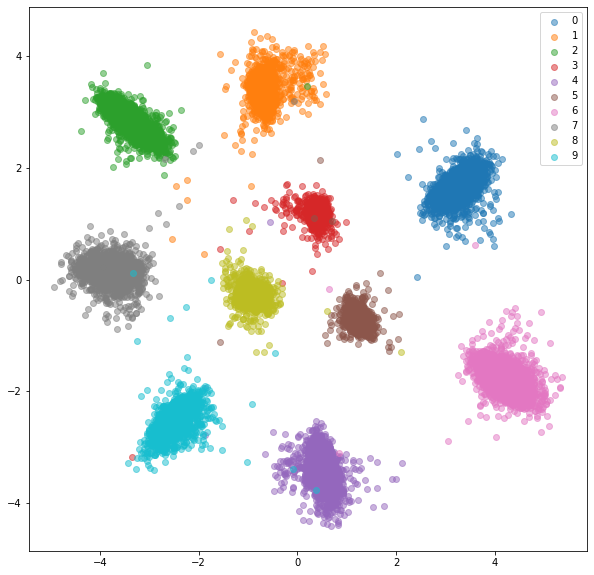

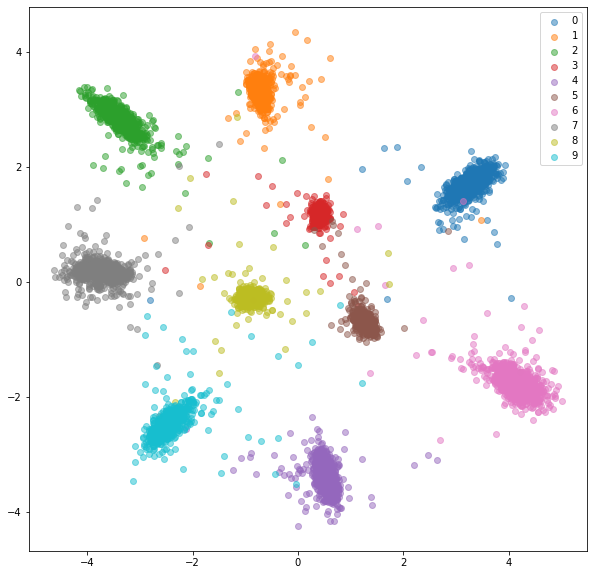

In [19]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

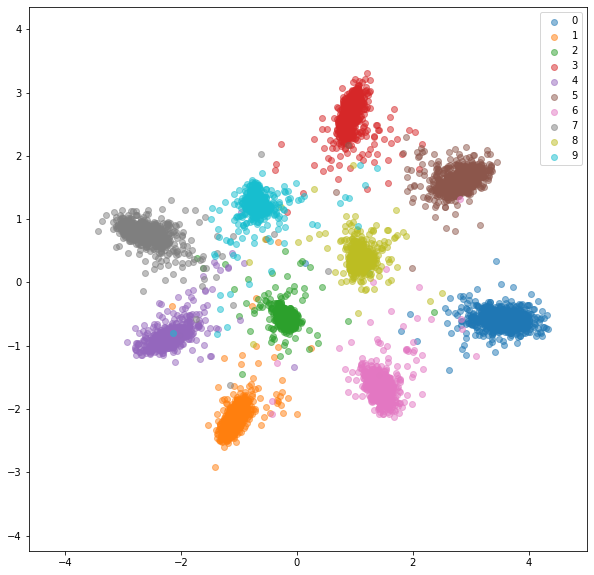

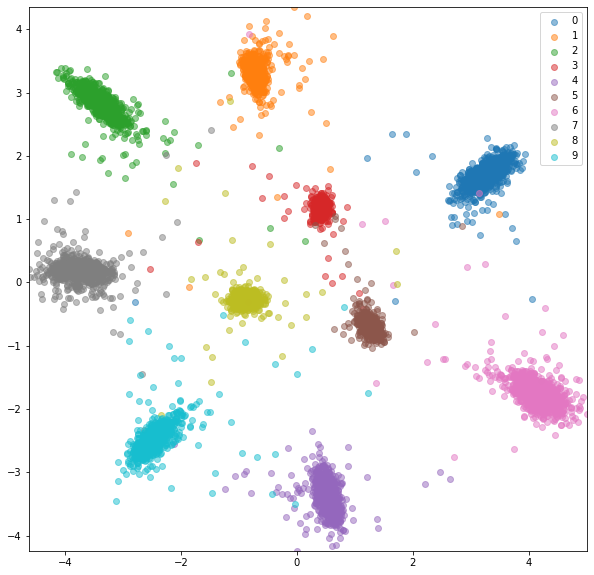

In [20]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

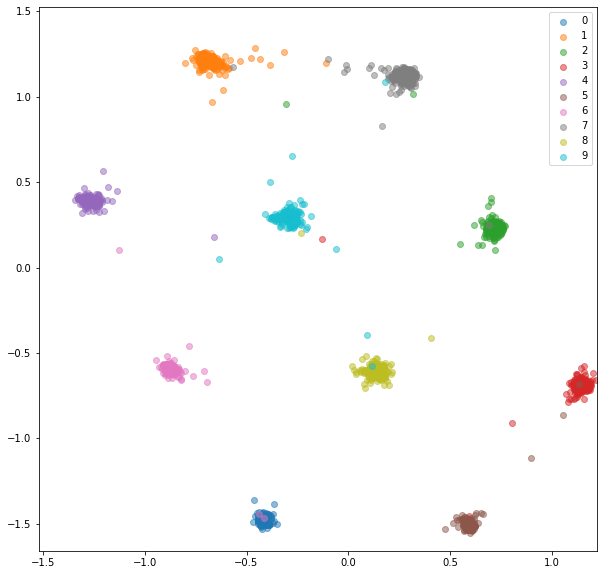

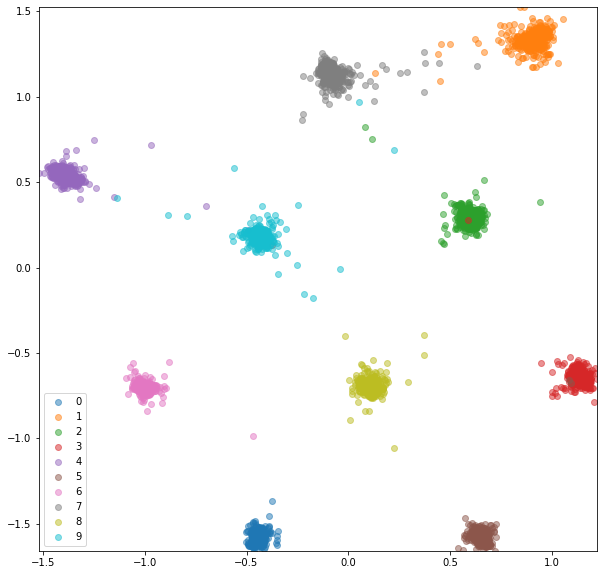

In [21]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)